# Importing Libraries

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

# Reading Clean Dataset

In [184]:
LOOKBACK = 7
data = pd.read_csv("cleaned_dataset.csv")

# Convert the "Date" column in the DataFrame to datetime format for time-related operations.
data["Date"] = pd.to_datetime(data["Date"])

# Select the "Date" column and store it in the variable 'train_dates'.
train_dates = data["Date"]

# Exclude the first 'LOOKBACK' dates from 'train_dates' to create a time window.
train_dates = train_dates[LOOKBACK:]

# Setting Device to GPU

In [185]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Formatting for LSTM

In [186]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)

    df.dropna(inplace=True)

    return df

shifted_df = prepare_dataframe_for_lstm(data, LOOKBACK)
shifted_df

,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7)
Date,,,,,,,,
1988-08-10,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680,0.8600,0.8655
1988-08-11,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680,0.8600
1988-08-12,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780,0.8680
1988-08-15,0.8880,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870,0.8780
1988-08-16,0.8880,0.8880,0.8835,0.9010,0.8875,0.8760,0.8710,0.8870
...,...,...,...,...,...,...,...,...
2023-09-15,3.8010,3.8215,3.7930,3.7920,3.8070,3.7165,3.7620,3.7860
2023-09-18,3.7790,3.8010,3.8215,3.7930,3.7920,3.8070,3.7165,3.7620
2023-09-19,3.7470,3.7790,3.8010,3.8215,3.7930,3.7920,3.8070,3.7165


In [187]:
shifted_df_as_np_before_scaling = shifted_df.to_numpy()
shifted_df_as_np_before_scaling

In [188]:
shifted_df_as_np_before_scaling.shape

(8896, 8)

# Scaling Data

In [189]:
# Create an instance of MinMaxScaler with a specified feature range of (-1, 1).
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scaler to the data in 'shifted_df_as_np_before_scaling' to learn scaling parameters.
scaler.fit(shifted_df_as_np_before_scaling)

# Transform (scale) the data in 'shifted_df_as_np_before_scaling' using the previously learned parameters.
shifted_df_as_np = scaler.transform(shifted_df_as_np_before_scaling)

In [190]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((8896, 7), (8896,))

In [191]:
X = dc(np.flip(X, axis=1))
X

array([[-0.88126588, -0.88380688, -0.88011088, ..., -0.87133287,
        -0.87872488, -0.87641488],
       [-0.88380688, -0.88011088, -0.87549088, ..., -0.87872488,
        -0.87641488, -0.87110187],
       [-0.88011088, -0.87549088, -0.87133287, ..., -0.87641488,
        -0.87110187, -0.86486486],
       ...,
       [ 0.43589744,  0.47770848,  0.47077847, ...,  0.48440748,
         0.47493647,  0.46477246],
       [ 0.47770848,  0.47077847,  0.47124047, ...,  0.47493647,
         0.46477246,  0.44998845],
       [ 0.47077847,  0.47124047,  0.48440748, ...,  0.46477246,
         0.44998845,  0.46338646]])

In [192]:
X = X.reshape((-1, LOOKBACK, 1))
y = y.reshape((-1, 1))
X.shape,y.shape

((8896, 7, 1), (8896, 1))

In [193]:
X = torch.tensor(X,dtype=torch.float32)
y = torch.tensor(y,dtype=torch.float32)
X

tensor([[[-0.881266],
         [-0.883807],
         [-0.880111],
         ...,
         [-0.871333],
         [-0.878725],
         [-0.876415]],

        [[-0.883807],
         [-0.880111],
         [-0.875491],
         ...,
         [-0.878725],
         [-0.876415],
         [-0.871102]],

        [[-0.880111],
         [-0.875491],
         [-0.871333],
         ...,
         [-0.876415],
         [-0.871102],
         [-0.864865]],

        ...,

        [[ 0.435897],
         [ 0.477708],
         [ 0.470778],
         ...,
         [ 0.484407],
         [ 0.474936],
         [ 0.464772]],

        [[ 0.477708],
         [ 0.470778],
         [ 0.471240],
         ...,
         [ 0.474936],
         [ 0.464772],
         [ 0.449988]],

        [[ 0.470778],
         [ 0.471240],
         [ 0.484407],
         ...,
         [ 0.464772],
         [ 0.449988],
         [ 0.463386]]])

# Preparing LSTM

In [194]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
dataset = TimeSeriesDataset(X, y)

In [195]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [196]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [197]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size=1, hidden_size=4, num_stacked_layers=1)
# Move the LSTM neural network 'rnn' to a specific computing device (e.g., CPU or GPU).
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

# Training and Optimising

In [198]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [199]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [200]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
"""
Adam does the gradient descent for me
"""
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.191
Batch 200, Loss: 0.045
Batch 300, Loss: 0.008
Batch 400, Loss: 0.006
Batch 500, Loss: 0.004
Val Loss: 0.002
***************************************************

Epoch: 2
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Batch 400, Loss: 0.001
Batch 500, Loss: 0.001
Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Bat

# Predicting

In [201]:
start_date = (train_dates.iloc[-1].date()+ timedelta(days=1)).strftime("%Y-%m-%d")
end_date = '2023-12-31'
test_dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Create a DataFrame with the date column
testset = pd.DataFrame({'Date': test_dates})
testset['Date'] = pd.to_datetime(testset['Date'])
testset.to_numpy()
testset


,Date
0,2023-09-22
1,2023-09-23
2,2023-09-24
3,2023-09-25
4,2023-09-26
...,...
96,2023-12-27
97,2023-12-28
98,2023-12-29
99,2023-12-30


## Scaling Data

In [202]:
shifted_df_as_np
shifted_df_as_np_flipped = np.fliplr(shifted_df_as_np)
shifted_df_as_np_flipped

array([[-0.88126588, -0.88380688, -0.88011088, ..., -0.87872488,
        -0.87641488, -0.87110187],
       [-0.88380688, -0.88011088, -0.87549088, ..., -0.87641488,
        -0.87110187, -0.86486486],
       [-0.88011088, -0.87549088, -0.87133287, ..., -0.87110187,
        -0.86486486, -0.87294987],
       ...,
       [ 0.43589744,  0.47770848,  0.47077847, ...,  0.47493647,
         0.46477246,  0.44998845],
       [ 0.47770848,  0.47077847,  0.47124047, ...,  0.46477246,
         0.44998845,  0.46338646],
       [ 0.47077847,  0.47124047,  0.48440748, ...,  0.44998845,
         0.46338646,  0.41580042]])

In [203]:
shifted_df_as_tensor = torch.tensor(shifted_df_as_np_flipped.copy())
torch.set_printoptions(precision=6)
last = shifted_df_as_tensor[-1][1:]
last = last.unsqueeze(0).unsqueeze(-1)
last.shape

torch.Size([1, 7, 1])

In [204]:
for i in range(test_dates.shape[0]):
    last = shifted_df_as_tensor[-1][1:]
    last = last.unsqueeze(0).unsqueeze(-1).float()
    with torch.no_grad():
        predicted = model(last.to(device)).to('cpu').numpy()
    row = torch.cat([shifted_df_as_tensor[-1][1:],torch.tensor(predicted).reshape(1)],dim=0).unsqueeze(0)
    quick_reverse = scaler.inverse_transform(row.to('cpu').numpy())
    new_row = {'Price':quick_reverse[0][7], 
               'Price(t-1)':quick_reverse[0][6],
               'Price(t-2)':quick_reverse[0][5],
               'Price(t-3)':quick_reverse[0][4],
               'Price(t-4)':quick_reverse[0][3],
               'Price(t-5)':quick_reverse[0][2],
               'Price(t-6)':quick_reverse[0][1],
               'Price(t-7)':quick_reverse[0][0]
               }
    shifted_df_as_tensor = torch.cat((shifted_df_as_tensor,row),dim=0)
    shifted_df = shifted_df._append(new_row,ignore_index=True)
print(shifted_df) 
    
final_set = scaler.inverse_transform(shifted_df_as_tensor.to('cpu').numpy())

         Price  Price(t-1)  Price(t-2)  Price(t-3)  Price(t-4)  Price(t-5)   
0     0.887500    0.876000    0.871000    0.887000    0.878000    0.868000  \
1     0.901000    0.887500    0.876000    0.871000    0.887000    0.878000   
2     0.883500    0.901000    0.887500    0.876000    0.871000    0.887000   
3     0.888000    0.883500    0.901000    0.887500    0.876000    0.871000   
4     0.888000    0.888000    0.883500    0.901000    0.887500    0.876000   
...        ...         ...         ...         ...         ...         ...   
8992  2.079621    2.088561    2.097637    2.106853    2.116212    2.125717   
8993  2.070814    2.079621    2.088561    2.097637    2.106853    2.116212   
8994  2.062136    2.070814    2.079621    2.088561    2.097637    2.106853   
8995  2.053584    2.062136    2.070814    2.079621    2.088561    2.097637   
8996  2.045155    2.053584    2.062136    2.070814    2.079621    2.088561   

      Price(t-6)  Price(t-7)  
0       0.860000    0.865500  
1

In [205]:
final_set

array([[0.8655    , 0.86      , 0.868     , ..., 0.871     , 0.876     ,
        0.8875    ],
       [0.86      , 0.868     , 0.878     , ..., 0.876     , 0.8875    ,
        0.901     ],
       [0.868     , 0.878     , 0.887     , ..., 0.8875    , 0.901     ,
        0.8835    ],
       ...,
       [2.1257173 , 2.11621153, 2.10685258, ..., 2.07962063, 2.07081361,
        2.06213572],
       [2.11621153, 2.10685258, 2.0976367 , ..., 2.07081361, 2.06213572,
        2.0535842 ],
       [2.10685258, 2.0976367 , 2.08856055, ..., 2.06213572, 2.0535842 ,
        2.04515538]])

In [206]:
testset
temp = shifted_df.tail(125)["Price"]
new_set = pd.DataFrame(columns=["Date","Price"]) 
for i in range(test_dates.shape[0]):
    item = {"Date":test_dates[i].date(), "Price": temp.iloc[i]}
    new_set = new_set._append(item, ignore_index=True)

new_set["Date"] = pd.to_datetime(new_set["Date"])
new_set.sort_values(by="Date",ascending=True)
new_set

,Date,Price
0,2023-09-22,3.782500
1,2023-09-23,3.830500
2,2023-09-24,3.787500
3,2023-09-25,3.779000
4,2023-09-26,3.785500
...,...,...
96,2023-12-27,2.339112
97,2023-12-28,2.326121
98,2023-12-29,2.313345
99,2023-12-30,2.300781


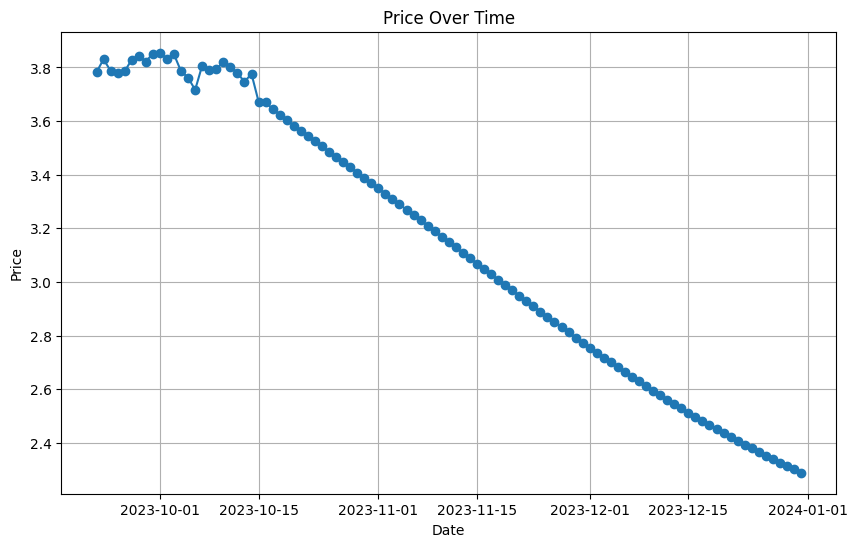

In [207]:
plt.figure(figsize=(10, 6))

plt.plot(new_set["Date"], new_set["Price"], marker='o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.grid(True)
plt.show()

# Plotting Everything

In [208]:
wholeset = pd.DataFrame()
wholeset = pd.concat([data["Date"],new_set["Date"]],axis=0)
wholeset = pd.to_datetime(wholeset)
wholeset.shape

(9004,)

In [209]:
all_prices = pd.DataFrame()
all_prices = pd.concat([data[0:7]['Price'], shifted_df[:]['Price']],axis=0)
all_prices.shape

(9004,)

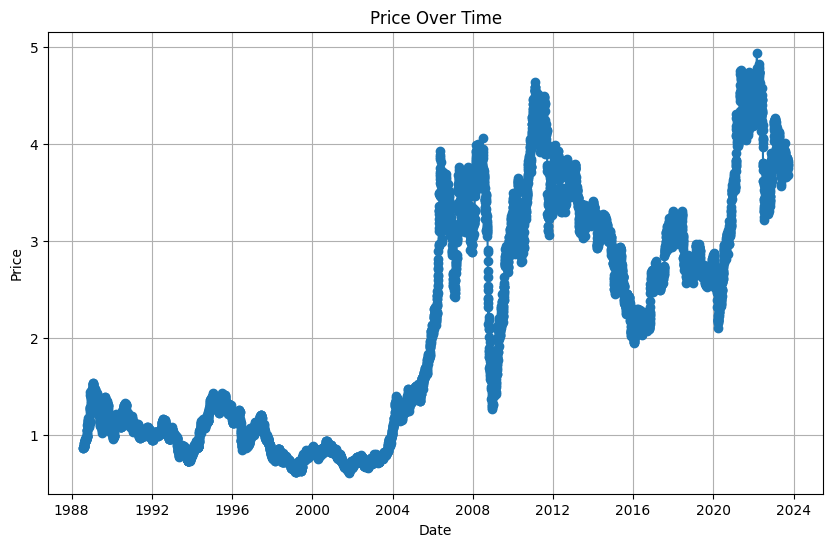

In [210]:

plt.figure(figsize=(10, 6))

plt.plot(data["Date"],data["Price"] , marker='o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.grid(True)
plt.show()

In [215]:
EVALUATION_YEARS = 5
QUARTER = 4
current_year = pd.Timestamp.now().year
data['year'] = data['Date'].dt.year
q4 = data[(data["Date"].dt.quarter == QUARTER) & (data['year'] >= current_year - EVALUATION_YEARS)]
data

,Date,Price,year
0,1988-08-01,0.8655,1988
1,1988-08-02,0.8600,1988
2,1988-08-03,0.8680,1988
3,1988-08-04,0.8780,1988
4,1988-08-05,0.8870,1988
...,...,...,...
8898,2023-09-15,3.8010,2023
8899,2023-09-18,3.7790,2023
8900,2023-09-19,3.7470,2023
8901,2023-09-20,3.7760,2023


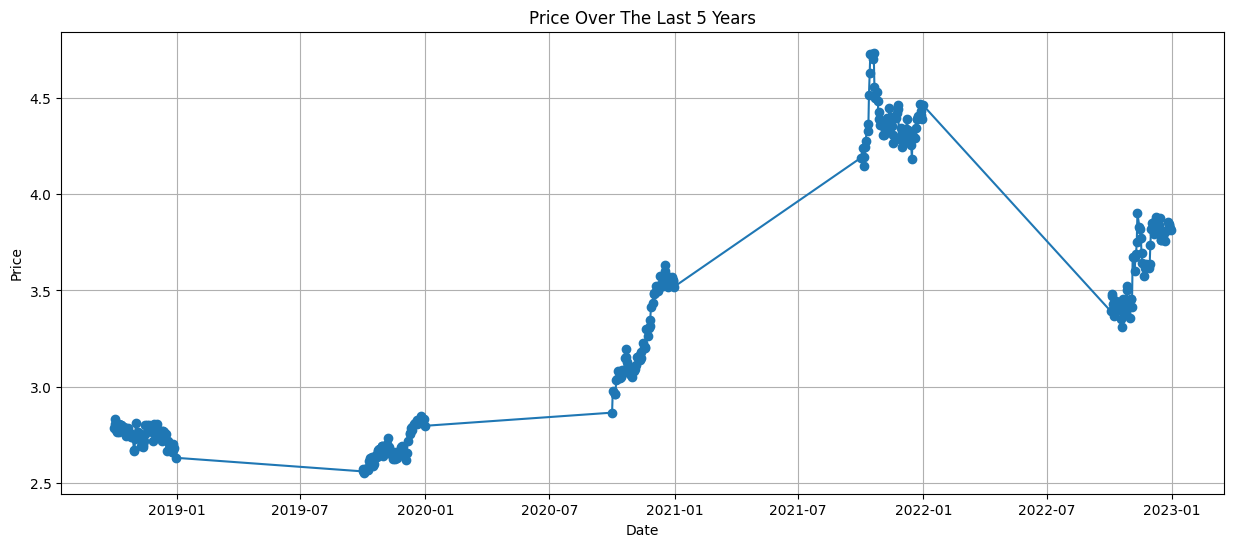

In [216]:
evaluation_set = pd.DataFrame()
evaluation_set = pd.to_datetime(wholeset)

plt.figure(figsize=(15, 6))

plt.plot(q4["Date"],q4['Price'], marker='o')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Price Over The Last {EVALUATION_YEARS} Years')
plt.grid(True)
plt.show()